In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.nn import init
from collections import Counter
import torchvision.transforms as transforms
from torchvision import datasets

## Data analysis and preprocessing

In [2]:
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
dataset = datasets.ImageFolder("data/train", transform=basic_transforms)
analysis_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
classes = dataset.classes

In [4]:
def visualize_images(dataloader, classes, figsize=(20,10), batch_size=16):
    plt.figure(figsize = figsize)
    images, labels = next(iter(dataloader))

    def imshow(img):
        img = img / 2 + 0.5     
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()
    images, labels = next(iter(dataloader))

    imshow(torchvision.utils.make_grid(images))

    print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

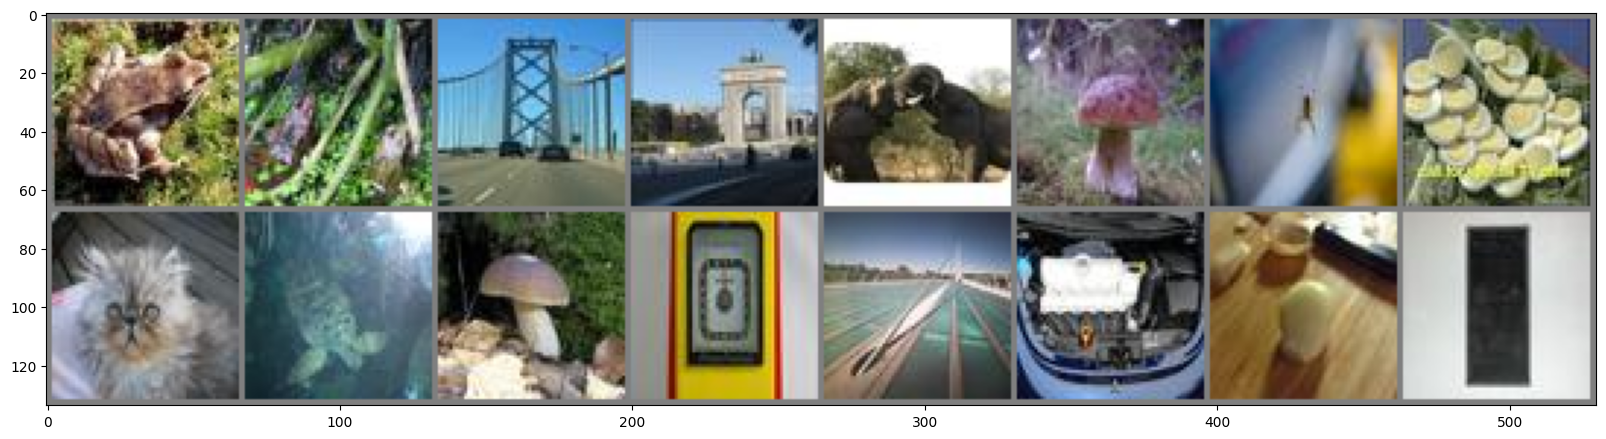

 frog  frog bridge memorial elephant fungus spider   egg   cat turtle fungus gauge bridge gauge   egg memorial


In [5]:
visualize_images(analysis_loader, classes, figsize=(20,10))

In [6]:
def verify_image_sizes(dataloader):
    sizes = {}
    for images, _ in dataloader:
        for image in images:
            size = image.size()
            sizes[size] = sizes.get(size, 0) + 1
    return sizes

In [7]:
verify_image_sizes(analysis_loader)

{torch.Size([3, 64, 64]): 88011}

All images are 64x64 pixels with three color channels (RGB).

In [8]:
def plot_bar(values, title, size=(10, 4)):
    plt.figure(figsize=size)
    plt.bar(*zip(*values.items()))
    plt.title(title)
    plt.show()

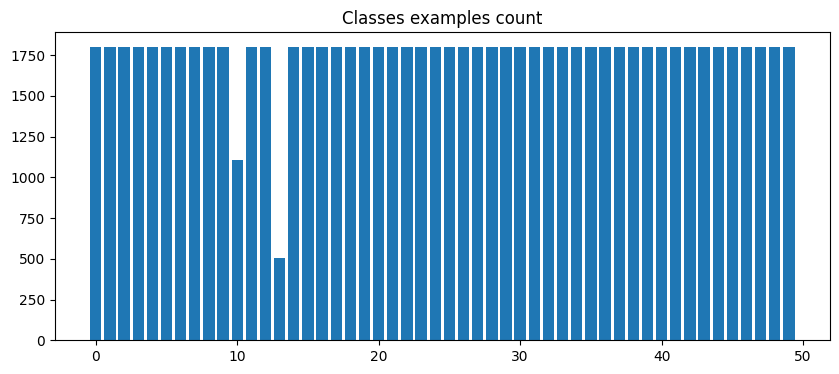

In [9]:
class_examples_num = dict(Counter(dataset.targets))
plot_bar(class_examples_num, "Classes examples count",  size=(10, 4))

In [10]:
print(f"{classes[10]}: {class_examples_num[10]}, {classes[13]}: {class_examples_num[13]}")


bread: 1108, carbon: 503


Dataset is nearly completely balanced at 1800 examples for almost all classes. Only class 10 (bread) and class 13(carbon) have respectively 1108 and 503 examples.

In [11]:
print("Dataset size: ", len(dataset))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Train set size: ", len(train_dataset))
print("Validation set size: ", len(val_dataset))

Dataset size:  88011
Train set size:  70408
Validation set size:  17603


In [12]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(24),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset.dataset.transform = train_transforms

In [53]:
class Model(nn.Module):
    def __init__(self, layers, device):
        super().__init__()
        self.layers = nn.ModuleList()
        for layer in layers:
            if "dropout" in layer:
                self.layers.append(nn.Dropout(layer["dropout"]))
            if "linear" in layer:
                self.layers.append(nn.Linear(*layer["linear"]))
            if "conv" in layer:
                self.layers.append(nn.Conv2d(*layer["conv"]))
            if "batch_norm" in layer and "linear" in layer:
                self.layers.append(nn.BatchNorm1d(layer["batch_norm"]))
            if "batch_norm" in layer and "conv" in layer:
                self.layers.append(nn.BatchNorm2d(layer["batch_norm"]))
            if "activation" in layer:
                self.layers.append(nn.ReLU())
            if "pool" in layer:
                self.layers.append(nn.MaxPool2d(layer["pool"]))
            if "flatten" in layer:
                self.layers.append(nn.Flatten(start_dim=1))
        self.initialize_weights()
        self.to(device)
        self.device = device

    def forward(self, x):
        for module in self.layers:
            x = module(x)
            # print(x.shape)
        return x

    def initialize_weights(self):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear) and i == len(self.layers) - 1:
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
            elif isinstance(layer, (nn.Linear, nn.Conv2d)):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
                nn.init.zeros_(layer.bias)

In [42]:
def train(
    model, training_dataset, epochs, lr, batch_size, class_weights=None, verbose=False
):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
    else:
        criterion = nn.CrossEntropyLoss()
    train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    model.train()
    for epoch in range(epochs):
        avg_loss = 0
        for input, label in train_dataloader:
            input, label = input.to(model.device), label.to(model.device)
            optimizer.zero_grad()
            y_pred = model(input)
            loss = criterion(y_pred, label)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
        losses.append(avg_loss / len(train_dataloader))
        if verbose:
            print(f"Epoch: {epoch}, loss: {avg_loss/len(train_dataloader)}")
    return (list(range(epochs)), losses)

In [51]:
architecture = [
        {"conv": (3, 32, 3, 1, 1), "activation": True, "pool": (2, 2)},
        {"conv": (32, 64, 3, 1, 1), "activation": True, "pool": (2)},
        {"flatten": True},
        {"linear": (16*16*64, 120), "activation": True},
        {"linear": (120, 84), "activation": True},
        {"linear": (84, 50)}, ]

In [ ]:
model = Model(architecture, device="cuda" if torch.cuda.is_available() else "cpu")
train(model, train_dataset, epochs=10, lr=0.001, batch_size=32, verbose=True)